# Working with databases from IPython

This is a small example of using Pandas to create, connect to, and query the "Mini SDSS" database we've created the last time.

In [1]:
import pandas as pd
import numpy as np
import sqlite3

This deletes the database file, if it exists. It's to ensure we're starting from scratch

In [2]:
import os
try:
    os.remove("msdss.db")
except OSError:
    pass

Connect to ("open") our SQLite database. If we were dealing with (for example) a MySQL database, this would make a connection to a MySQL server (that may be local to your machine, but also (more likely) somewhere else, on a remote server).

If the database doesn't exist, SQLite's behavior is to automatically create it.

## Importing data

In [3]:
con = sqlite3.connect("msdss.db")

Now we'll create the tables. The backticks -- the \` characters -- are a way to quote names in SQLite's dialect of SQL. They're not strictly necessary here (they would be if, say, you wanted to name the table "my sources", i.e., have a whitespace as a part of the name)

In [4]:
con.execute("""
CREATE TABLE `sources` (
    `run`      INTEGER,
    `rerun`    INTEGER,
    `camcol`   INTEGER,
    `field`    INTEGER,
    `obj`      INTEGER,
    `type`     INTEGER,

    `ra`          REAL,
    `dec`         REAL,
    `psfMag_r`    REAL,
    `psfMag_g`    REAL,
    `psfMagErr_r` REAL,
    `psfMagErr_g` REAL
);
""")

In [5]:
con.execute("""
CREATE TABLE `runs` (
    `run`         INTEGER,
    `ra`          REAL,
    `dec`         REAL,
    `mjdstart`    REAL,
    `mjdend`      REAL,
    `node`        REAL,
    `inclination` REAL,
    `mu0`         REAL,
    `nu0`         REAL
);
""")

Here we use pandas' `read_cvs` function to read the `runs.txt` file into memory. This is very similar to `np.genfromtxt` and `np.loadtext`, but much more powerful. See the documentation for details.

One particular thing to note is the `index_col` keyword. It tells Pandas which column can be used to uniquely refer to any row.

In [6]:
runs = pd.read_csv('runs.txt', 
            sep=" ", header=None, skiprows=1, 
            names=['run', 'ra', 'dec', 'mjdstart', 'mjdend', 'node', 'inclination', 'mu0', 'nu0'],
            index_col = 'run')

Pandas loaded the contents of `runs.txt` into its own data structure called a `DataFrame`. For now, think of a data frame as a table.

In [7]:
type(runs)

pandas.core.frame.DataFrame

You can generally use a `DataFrame` the same way you'd use a numpy array (i.e., subscripting and slicing works)

In [8]:
runs[:5]

,ra,dec,mjdstart,mjdend,node,inclination,mu0,nu0
run,,,,,,,,
94,336.432779,-1.044294,51075.233211,51075.455014,286.855205,0.009477,336.432667,-1.051509
109,396.241809,-1.250557,51078.390783,51078.474944,283.391747,0.008279,36.241879,-1.258186
125,350.469743,-1.252750,51081.255759,51081.495289,287.818732,0.007781,350.469664,-1.259661
211,402.581109,-1.265170,51115.307000,51115.462055,283.219780,0.007975,42.581196,-1.272121
240,375.189678,-1.264403,51132.185032,51132.248851,290.578187,0.010103,15.189657,-1.274462


Pandas does its best to infer the correct data types for the data in the file. Let's see what it did for this file:

In [9]:
runs.dtypes

ra             float64
dec            float64
mjdstart       float64
mjdend         float64
node           float64
inclination    float64
mu0            float64
nu0            float64
dtype: object

Now, let's load the sources:

In [10]:
sources = pd.read_csv('sample.csv', index_col=['run', 'rerun', 'camcol', 'field', 'obj'])

In [11]:
sources.dtypes

type             int64
ra             float64
dec            float64
psfMag_r       float64
psfMag_g       float64
psfMagErr_r    float64
psfMagErr_g    float64
dtype: object

You can be explicit about column datatypes:

In [23]:
sources = pd.read_csv('sample.csv',
                        dtype={
                                'run': np.int16,
                                'rerun': np.int16,
                                'camcol': np.int8,
                                'field': np.int16,
                                'obj':  np.int32,
                                'type': np.int16,
                                'psfMag_r': np.float32,
                                'psfMag_g': np.float32,
                                'psfMagErr_r': np.float32,
                                'psfMagErr_g': np.float32,
                              },
                        index_col=['run', 'rerun', 'camcol', 'field', 'obj'])

In [29]:
sources.dtypes

type             int16
ra             float64
dec            float64
psfMag_r       float32
psfMag_g       float32
psfMagErr_r    float32
psfMagErr_g    float32
dtype: object

Can we deal with missing data?

In [30]:
sources[sources["psfMagErr_g"] < 0][:5]

type          ra        dec  psfMag_r  psfMag_g  \
run  rerun camcol field obj                                                     
3366 301   1      80    3009     0   12.231521  41.113295   -9999.0   -9999.0   
                        3010     0   12.082267  41.206067   -9999.0   -9999.0   
                        3011     0   12.184899  41.142380   -9999.0   -9999.0   
3996 301   1      162   1413     0  228.319441   9.958091   -9999.0   -9999.0   
4894 301   1      174   592      0  352.075004  -0.932815   -9999.0   -9999.0   

                              psfMagErr_r  psfMagErr_g  
run  rerun camcol field obj                             
3366 301   1      80    3009      -9999.0      -9999.0  
                        3010      -9999.0      -9999.0  
                        3011      -9999.0      -9999.0  
3996 301   1      162   1413      -9999.0      -9999.0  
4894 301   1      174   592       -9999.0      -9999.0

In [31]:
sources = pd.read_csv('sample.csv',
                        dtype={
                                'run': np.int16,
                                'rerun': np.int16,
                                'camcol': np.int8,
                                'field': np.int16,
                                'obj':  np.int32,
                                'type': np.int16,
                                'psfMag_r': np.float32,
                                'psfMag_g': np.float32,
                                'psfMagErr_r': np.float32,
                                'psfMagErr_g': np.float32,
                              },
                        index_col=['run', 'rerun', 'camcol', 'field', 'obj'],
                        na_values=["-9999"])

No more -9999s!

In [32]:
sources[sources["psfMagErr_g"] < 0][:5]

,,,,,type,ra,dec,psfMag_r,psfMag_g,psfMagErr_r,psfMagErr_g
run,rerun,camcol,field,obj,,,,,,,


Now there are NaNs:

In [33]:
sources[sources["psfMagErr_g"].isnull()][:5]

type          ra        dec  psfMag_r  psfMag_g  \
run  rerun camcol field obj                                                     
3366 301   1      80    3009     0   12.231521  41.113295       NaN       NaN   
                        3010     0   12.082267  41.206067       NaN       NaN   
                        3011     0   12.184899  41.142380       NaN       NaN   
3996 301   1      162   1413     0  228.319441   9.958091       NaN       NaN   
4894 301   1      174   592      0  352.075004  -0.932815       NaN       NaN   

                              psfMagErr_r  psfMagErr_g  
run  rerun camcol field obj                             
3366 301   1      80    3009          NaN          NaN  
                        3010          NaN          NaN  
                        3011          NaN          NaN  
3996 301   1      162   1413          NaN          NaN  
4894 301   1      174   592           NaN          NaN

Let's be a bit more specific about where -9999 is to be considered as a marker for missing data:

In [36]:
sources = pd.read_csv('sample.csv',
                        dtype={
                                'run': np.int16,
                                'rerun': np.int16,
                                'camcol': np.int8,
                                'field': np.int16,
                                'obj':  np.int32,
                                'type': np.int16,
                                'psfMag_r': np.float32,
                                'psfMag_g': np.float32,
                                'psfMagErr_r': np.float32,
                                'psfMagErr_g': np.float32,
                              },
                       index_col=['run', 'rerun', 'camcol', 'field', 'obj'],
                       na_values={
                            'psfMagErr_g': ["-9999"],
                            'psfMagErr_r': ["-9999"],
                            'psfMag_g': ["-9999"],
                            'psfMag_r': ["-9999"],
                       },
                       verbose=True
                     )

Tokenization took: 41.13 ms
Type conversion took: 73.42 ms
Parser memory cleanup took: 0.03 ms


In [37]:
sources[sources["psfMagErr_g"].isnull()][:5]

type          ra        dec  psfMag_r  psfMag_g  \
run  rerun camcol field obj                                                     
3366 301   1      80    3009     0   12.231521  41.113295       NaN       NaN   
                        3010     0   12.082267  41.206067       NaN       NaN   
                        3011     0   12.184899  41.142380       NaN       NaN   
3996 301   1      162   1413     0  228.319441   9.958091       NaN       NaN   
4894 301   1      174   592      0  352.075004  -0.932815       NaN       NaN   

                              psfMagErr_r  psfMagErr_g  
run  rerun camcol field obj                             
3366 301   1      80    3009          NaN          NaN  
                        3010          NaN          NaN  
                        3011          NaN          NaN  
3996 301   1      162   1413          NaN          NaN  
4894 301   1      174   592           NaN          NaN

Now, store this into our database

In [38]:
runs.to_sql('runs', con, if_exists='append')

In [39]:
sources.to_sql('sources', con, if_exists='append')

It's good practice to close the database when you're done with it. This ensures the memory is freed, and there are no open connections to the database left lingering (i.e., if the database limits the number of possible simultaneous connections, this may be important).

In [40]:
con.close()
del runs
del sources

## Querying the database

Connect to the database

In [41]:
con = sqlite3.connect("msdss.db")

Execute the SQL, using pandas' `read_sql` function.

In [42]:
result = pd.read_sql("""
    SELECT
        sources.ra, sources.dec, sources.run, mjdstart
    FROM
        sources JOIN runs ON sources.run = runs.run
""", con)

In [43]:
result[:5]

,ra,dec,run,mjdstart
0,8.129444,26.626617,7757,54764.323971
1,8.127839,26.627246,7757,54764.323971
2,8.127323,26.625120,7757,54764.323971
3,24.516117,-1.165794,4288,52971.187293
4,24.517941,-1.179207,4288,52971.187293


In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Let's plot it!

Text(0,0.5,'$\\delta$')

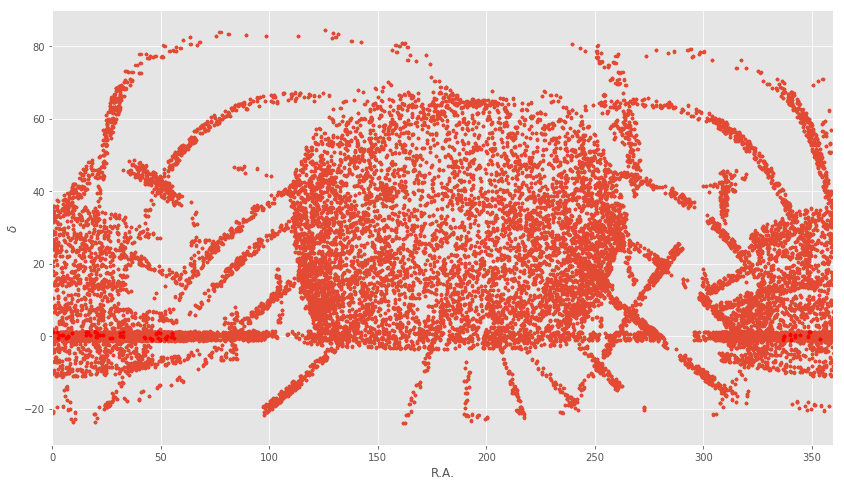

In [45]:
fig, ax = plt.subplots(figsize=(14,8))
ax.scatter(result.ra, result.dec, marker='.')

someRun = result[result.run == 94]
ax.scatter(someRun.ra, someRun.dec, color='r', marker='.')

ax.set_xlim(0, 360)
ax.set_ylim(-30, 90)

ax.set_xlabel("R.A.")
ax.set_ylabel("$\delta$")

## Homework #4

Take the SDSS SQL Tutorial at:
    
    http://cas.sdss.org/dr14/en/help/howto/search/
        
to practice SQL, and familiarize yourselves with SDSS' SQL database language flavor and the [database schema](http://cas.sdss.org/dr14/en/help/browser/browser.asp). Also, open an account on [SDSS CASJobs] http://skyserver.sdss.org/casjobs/) (if you don't have one already.

Then, write and execute a SQL query that returns the object ID (`bestObjID`), the ra, dec, and redshift (column `z`), of the five most distant quasars in a 2-degree circle around $\alpha = 180^\circ$, $\delta = 60^\circ$. Note: You don't have to use CASJobs to execute the query; you can use the boxes from tutorial pages, or the form [available here](https://skyserver.sdss.org/dr14/en/tools/search/sql.aspx).

Download the resulting table in CSV format and include it with your homework.

### Solution